In [1]:
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# import pmdarima as pm
# from pmdarima.arima import auto_arima

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests
import statsmodels.tsa.vector_ar.vecm as vecm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from prophet import Prophet
from prophet.diagnostics import cross_validation

from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 18, 8
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
dataset = pd.read_csv('datasets/HomeC.csv')

C:\Windows\Temp\ipykernel_12096\1788662014.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('datasets/HomeC.csv')


In [4]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [5]:
dataset.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [6]:
dataset.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,...,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,0.014139,...,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936,202.356843,0.002598,38.694013,0.056453
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199,0.057967,0.014292,...,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,...,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,...,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000,148.000000,0.000000,24.600000,0.000000
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,...,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000,208.000000,0.000000,39.030000,0.000000
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,0.013100,...,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000,295.000000,0.000000,54.790000,0.000000
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,...,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.490000,0.840000


In [7]:
dataset.isnull().sum()

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [8]:
dataset.describe(include='all')

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
count,5.039110e+05,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,...,503910.000000,503910,503910.000000,503910.000000,503910.000000,503910.0,503910.000000,503910.000000,503910.000000,503910.000000
unique,5.039110e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,NaN,NaN,NaN,118.0,NaN,NaN,NaN,NaN
top,1.451624e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Clear,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
freq,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,376730,NaN,NaN,NaN,63596.0,NaN,NaN,NaN,NaN
mean,NaN,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,...,9.253444,NaN,48.263382,1016.301625,6.649936,NaN,202.356843,0.002598,38.694013,0.056453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,...,0.270000,NaN,-32.080000,986.400000,0.000000,NaN,0.000000,0.000000,-27.240000,0.000000
25%,NaN,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,...,9.420000,NaN,31.090000,1011.290000,3.660000,NaN,148.000000,0.000000,24.600000,0.000000
50%,NaN,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,...,10.000000,NaN,50.320000,1016.530000,5.930000,NaN,208.000000,0.000000,39.030000,0.000000
75%,NaN,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,...,10.000000,NaN,66.260000,1021.480000,8.940000,NaN,295.000000,0.000000,54.790000,0.000000


In [9]:
dataset.isna().sum()

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [10]:
for col in dataset:
  dataset.nunique()
col

'precipProbability'

In [11]:
dataset.shape

(503911, 32)

In [12]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
503910,\,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Drop the line with missing values
dataset.dropna(inplace=True)

In [14]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [15]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503910 entries, 0 to 503909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503910 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability


In [16]:
obj_cols = ['icon', 'summary', 'cloudCover']
for i in obj_cols:
    print(f'{i} takes the following unique values {dataset[i].unique()}')

icon takes the following unique values ['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind' 'fog']
summary takes the following unique values ['Clear' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Drizzle' 'Light Rain'
 'Rain' 'Light Snow' 'Flurries' 'Breezy' 'Snow' 'Rain and Breezy' 'Foggy'
 'Breezy and Mostly Cloudy' 'Breezy and Partly Cloudy'
 'Flurries and Breezy' 'Dry' 'Heavy Snow']
cloudCover takes the following unique values ['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.3

In [17]:
dataset[dataset['cloudCover']=='cloudCover'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57],
           dtype='int64')

In [18]:
dataset['cloudCover'].replace('cloudCover', np.nan, inplace=True)
dataset['cloudCover'].fillna(method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')

In [19]:
dataset.columns = [col.replace(' [kW]', '') for col in dataset.columns]
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [20]:
dataset['sum_Furnace'] = dataset[['Furnace 1','Furnace 2']].sum(axis=1)
dataset['avg_Kitchen'] = dataset[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)

In [21]:
dataset = dataset.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)
dataset = dataset.drop(['Furnace 1','Furnace 2'], axis=1)
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Home office',
       'Fridge', 'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'sum_Furnace', 'avg_Kitchen'],
      dtype='object')

In [22]:
dataset['time'].head()

0    1451624400
1    1451624401
2    1451624402
3    1451624403
4    1451624404
Name: time, dtype: object

In [23]:
import time 
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(dataset['time'].iloc[0]))))

 start  2016-01-01 10:30:00


In [24]:
time_index = pd.date_range('2016-01-01 05:00', periods=len(dataset),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
dataset = dataset.set_index(time_index)
dataset = dataset.drop(['time'], axis=1)
dataset.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    0.932833
2016-01-01 05:01:00    0.934333
2016-01-01 05:02:00    0.931817
2016-01-01 05:03:00    1.022050
2016-01-01 05:04:00    1.139400
2016-12-16 03:25:00    1.601233
2016-12-16 03:26:00    1.599333
2016-12-16 03:27:00    1.924267
2016-12-16 03:28:00    1.978200
2016-12-16 03:29:00    1.990950
Name: use, dtype: float64

In [25]:
dataset.shape

(503910, 28)

<AxesSubplot:>

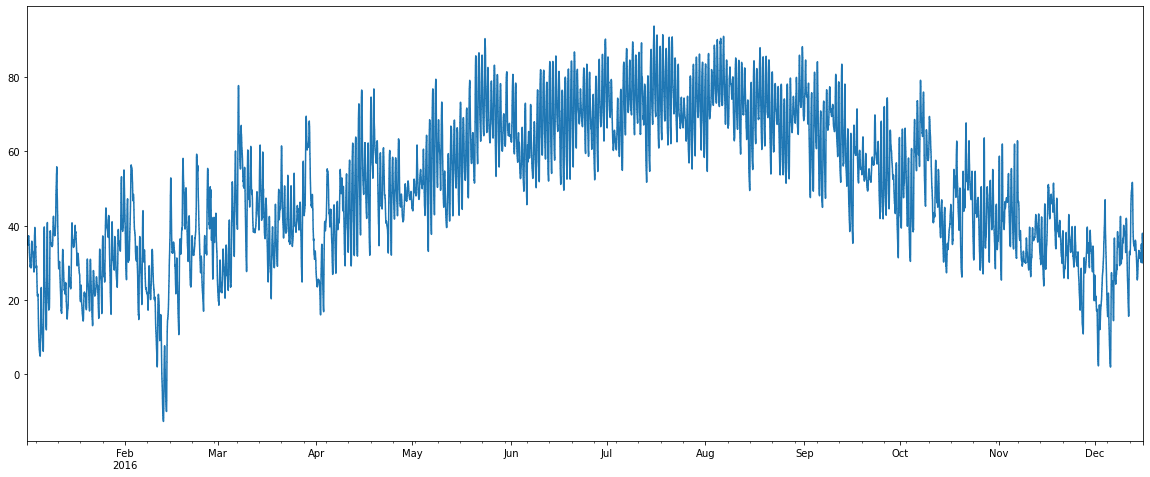

In [26]:
dataset['temperature'].plot(figsize=(20,8))

<AxesSubplot:>

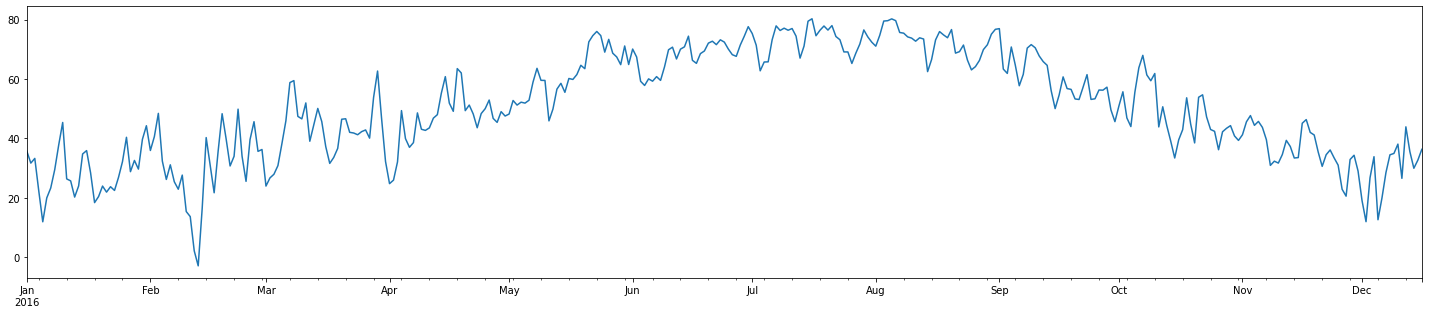

In [27]:
dataset['temperature'].resample(rule='D').mean().plot(figsize=(25,5))

In [28]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)

<AxesSubplot:>

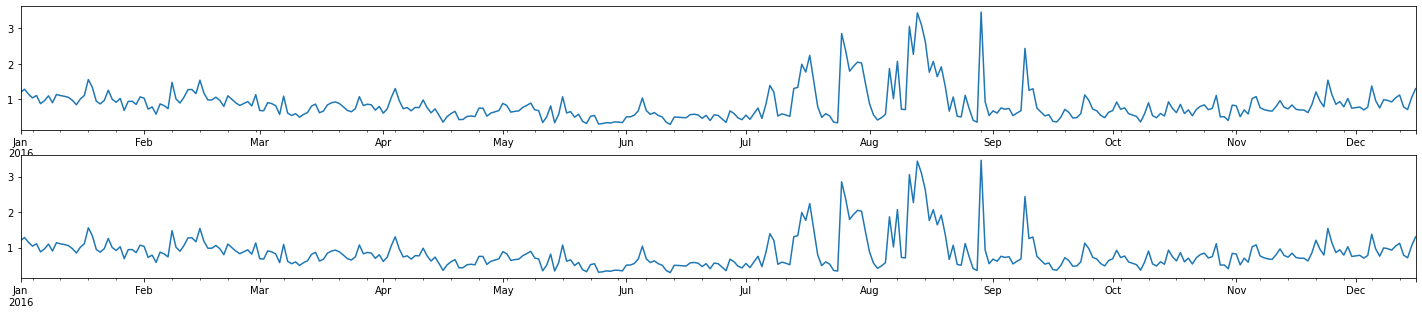

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1)
dataset['use'].resample('D').mean().plot(ax=axes[0])
dataset['House overall'].resample('D').mean().plot(ax=axes[1])

In [30]:
# dataset = dataset.drop(columns=['House overall'])
# dataset.shape

In [31]:
dataset['icon'].value_counts()

clear-night            194536
clear-day              182252
rain                    43081
partly-cloudy-day       39492
partly-cloudy-night     27324
snow                     7550
cloudy                   6041
wind                     2660
fog                       974
Name: icon, dtype: int64

In [32]:
dataset = dataset.drop(columns=['summary', 'icon'])
dataset.shape

(503910, 26)

In [33]:
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [34]:
dataset['cloudCover'][56:60]

2016-01-01 05:56:00    0.75
2016-01-01 05:57:00    0.75
2016-01-01 05:58:00    0.75
2016-01-01 05:59:00    0.75
Freq: T, Name: cloudCover, dtype: float64

In [35]:
dataset[dataset['cloudCover']=='cloudCover'].shape

(0, 26)

In [36]:
dataset['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 05:00:00 to 2016-12-16 03:29:00
Freq: T
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   House overall        503910 non-null  float64
 3   Dishwasher           503910 non-null  float64
 4   Home office          503910 non-null  float64
 5   Fridge               503910 non-null  float64
 6   Wine cellar          503910 non-null  float64
 7   Garage door          503910 non-null  float64
 8   Barn                 503910 non-null  float64
 9   Well                 503910 non-null  float64
 10  Microwave            503910 non-null  float64
 11  Living room          503910 non-null  float64
 12  Solar                503910 non-null  float64
 13  temperature          503910 non-null  float64
 14  humidity             50391

<AxesSubplot:>

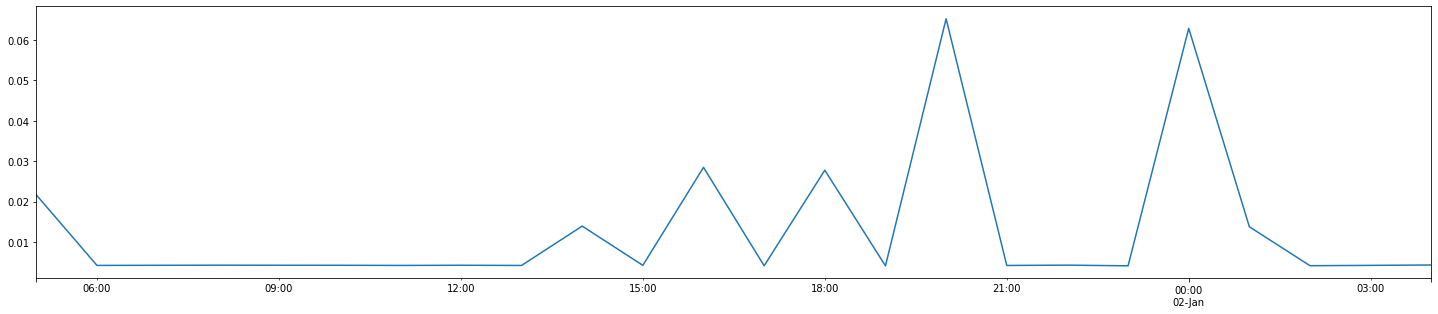

In [38]:
dataset['Microwave'].resample("h").mean().iloc[:24].plot()

[Text(0.5, 0, 'Daily Hours'), Text(0, 0.5, 'Microwave Usage (kW)')]

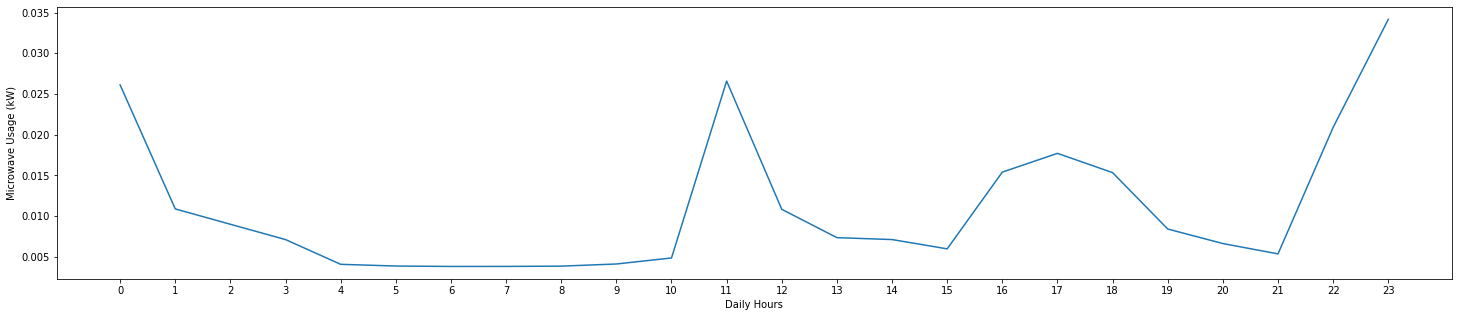

In [39]:
dataset.groupby(dataset.index.hour).mean()['Microwave'].plot(xticks=np.arange(24)).set(xlabel='Daily Hours', ylabel='Microwave Usage (kW)')

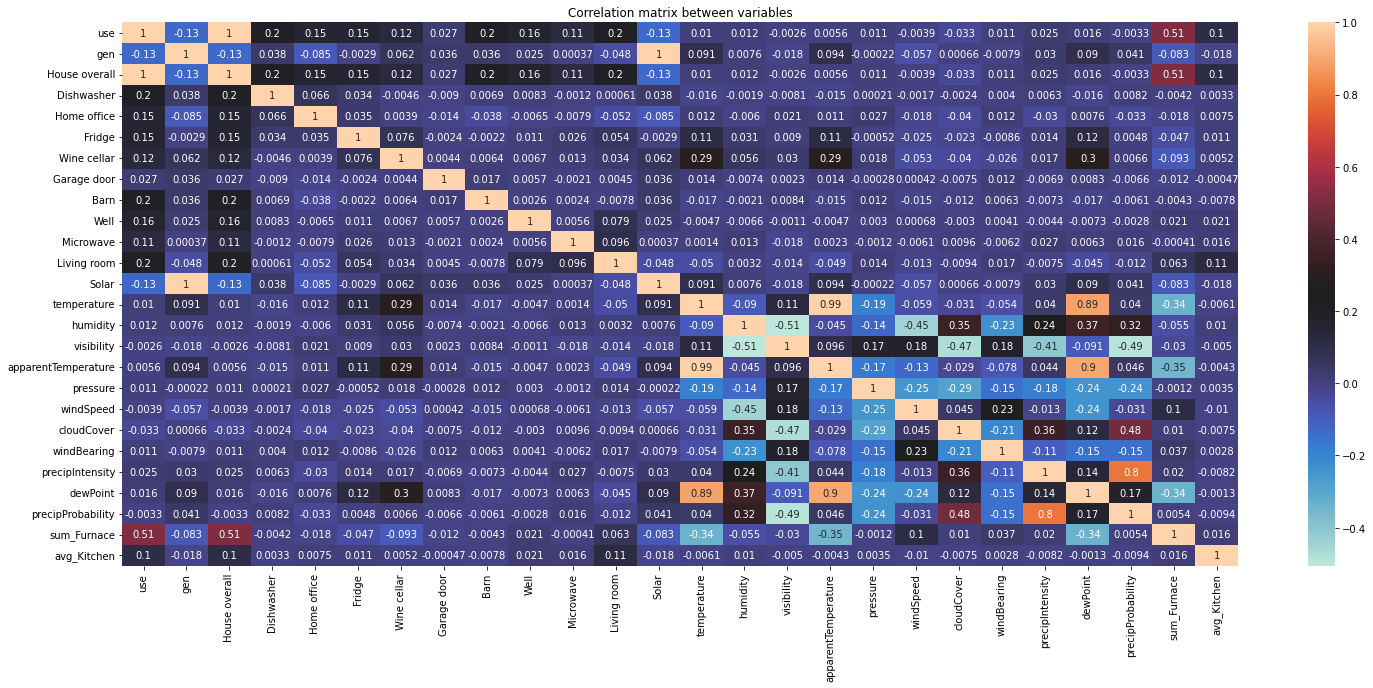

In [40]:
plt.figure(figsize=(25,10))
sns.heatmap(dataset.corr(), annot=True, cmap='icefire').set_title('Correlation plot')
plt.title('Correlation matrix between variables')
plt.show()

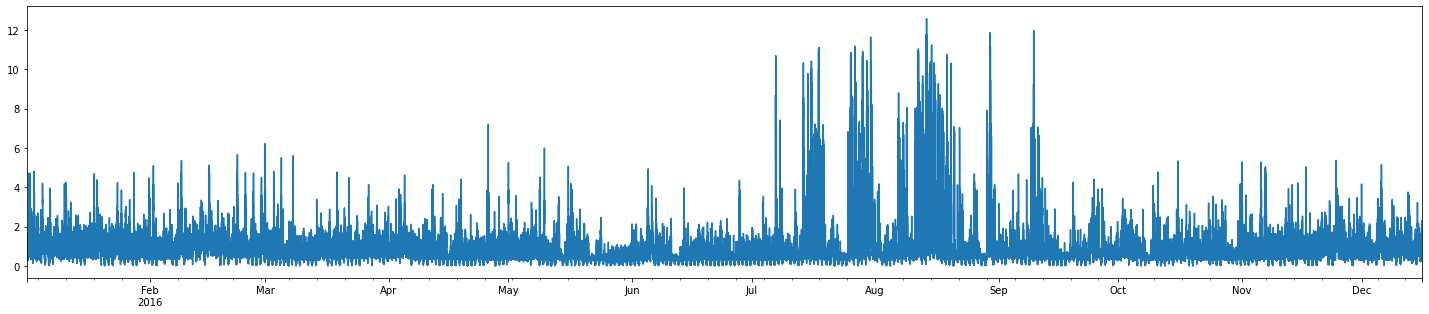

In [41]:
# Simple Moving Average
dataset['use'] = dataset['use'].rolling(10).mean().plot()

(None, None)

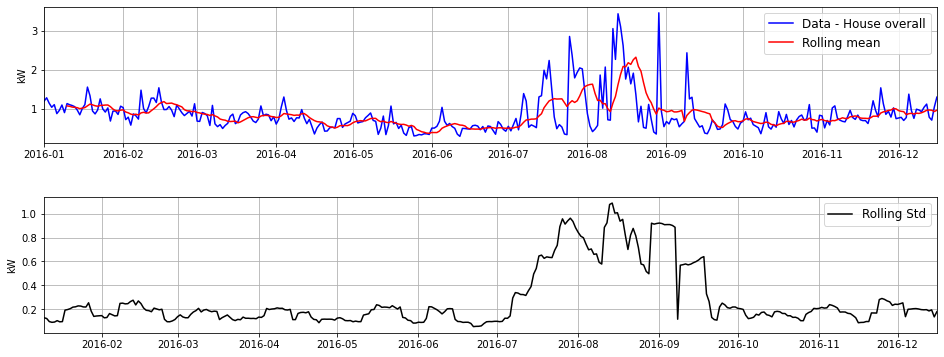

In [42]:
data_daily = dataset['House overall'].resample('d').mean()
rollingMEAN = data_daily.rolling(window=10).mean()
rollingSTD = data_daily.rolling(window=10).std()
#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax1.plot(data_daily, c='blue',label='Data - House overall')
ax1.plot(rollingMEAN, c='red', label='Rolling mean')
ax2.plot(rollingSTD, c='black',label = 'Rolling Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

In [43]:
from statsmodels.tsa.stattools import adfuller

resultDFtest = adfuller(data_daily, autolag='AIC')
Out = pd.Series(resultDFtest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key1, value1 in resultDFtest[4].items():
    Out['Critical Value (%s)'%key1] = value1
    
print('DICK-FULLER RESULTS: \n\n{}'.format(Out))

DICK-FULLER RESULTS: 

Test Statistic                  -2.988003
p-value                          0.036030
#Lags Used                      10.000000
Number of Observations Used    340.000000
Critical Value (1%)             -3.449730
Critical Value (5%)             -2.870079
Critical Value (10%)            -2.571319
dtype: float64


In [44]:
size = int(len(data_daily)*0.7)
train = data_daily[:size]
test = data_daily[size:]
print('Number of points in series:', len(data_daily))
print('Number of points in train:', len(train))
print('Number of points in test:', len(test))

Number of points in series: 351
Number of points in train: 245
Number of points in test: 106


In [45]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,1,1))
#model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(5,0,1,12))
model_fit = model.fit()
print('Akaike information criterion: ', model_fit.aic)

Akaike information criterion:  258.46236940930976


                               SARIMAX Results                                
Dep. Variable:          House overall   No. Observations:                  245
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -125.231
Date:                Tue, 21 Feb 2023   AIC                            258.462
Time:                        01:28:17   BIC                            272.451
Sample:                    01-01-2016   HQIC                           264.096
                         - 09-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4590      0.051      9.051      0.000       0.360       0.558
ar.L2          0.0999      0.037      2.667      0.008       0.026       0.173
ma.L1         -0.9438      0.026    -35.670      0.0

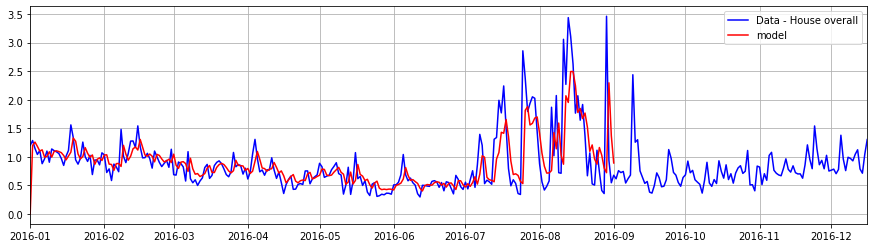

In [46]:
plt.figure(figsize=(15,4))
plt.plot(data_daily, c='blue',label='Data - House overall')
plt.plot(model_fit.predict(dynamic=False), c='red', label='model')
plt.legend()
plt.grid(), plt.margins(x=0);
print(model_fit.summary())

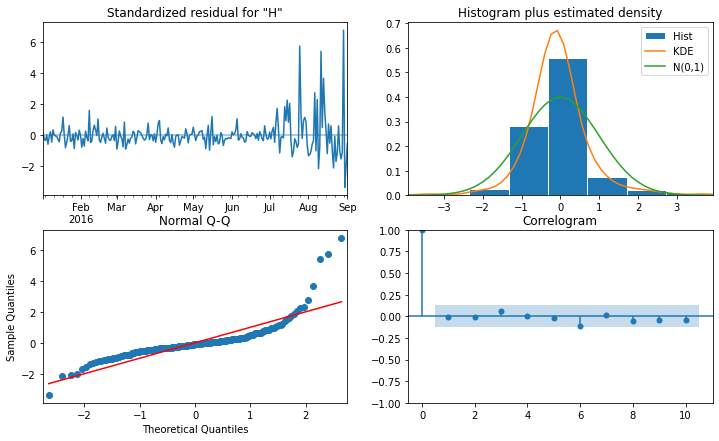

In [47]:
# Residuals

model_fit.plot_diagnostics(figsize=(12,7))
plt.show()

MSE: 0.259
RMSE: 0.509
MAE: 0.463
MAPE: 0.722
MASE: 1.886
R^2 score: -2.379


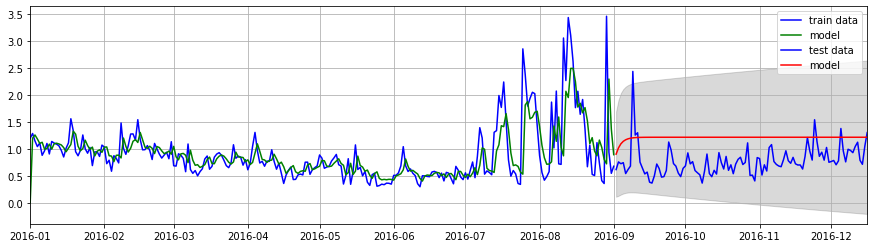

In [48]:
from sklearn.metrics import mean_absolute_error,r2_score

new_fit = model_fit.append(data_daily[size:size+1], refit=False)
forecast = model_fit.forecast(len(test))
confidence = model_fit.get_forecast(len(test)).conf_int(0.05)
#forecast = model_fit.predict(246, 351)
plt.figure(figsize=(15,4))
plt.plot(train, c='blue',label='train data')
plt.plot(model_fit.predict(dynamic=False), c='green', label='model')
plt.plot(test, c='blue',label='test data')
plt.plot(forecast, c='red', label='model')
plt.fill_between(confidence.index,confidence['lower House overall'],
                 confidence['upper House overall'], color='k', alpha=.15)
plt.legend()
plt.grid(), plt.margins(x=0);
# calcolo errore
print('MSE: %.3f' % (mean_squared_error(test, forecast)))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, forecast)))
MAE = mean_absolute_error(test, forecast)
MAPE = np.mean(np.abs(forecast - test)/np.abs(test))
MASE = np.mean(np.abs(test - forecast))/(np.abs(np.diff(train)).sum()/(len(train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(test, forecast))

In [49]:
import joblib

# Save the trained model as a pickle file
joblib.dump(model, 'model.pkl')

['model.pkl']

In [52]:
import pickle
import numpy as np
import statsmodels.api as sm
import joblib

# Load the trained model from the `model.pkl` file
joblib.load('model.pkl')

# Determine the length of time series you want to create
num_time_steps = 1000

# Generate a set of random inputs
random_inputs = np.random.normal(loc=0, scale=1, size=num_time_steps)

# Use the trained ARIMA model to generate synthetic time series
synthetic_time_series = model.predict(random_inputs)

# Combine the random inputs and synthetic time series to create a synthetic time series dataset
synthetic_data = np.column_stack((random_inputs, synthetic_time_series))


NotImplementedError: 